In [1]:
import pickle
import numpy as np
import matplotlib.pylab as plt
import os
from scipy import interpolate

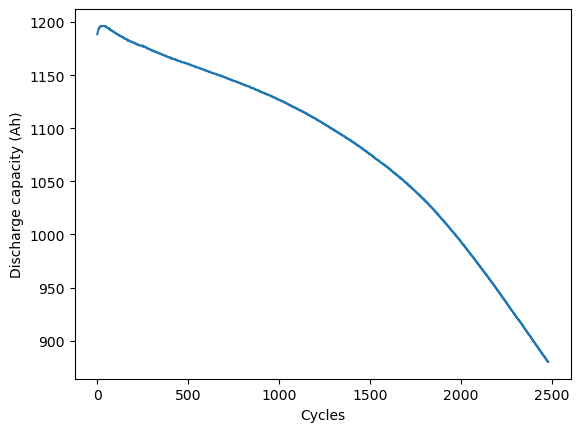

In [47]:
def interp(v, q, num):
    f = interpolate.interp1d(v,q,kind='linear')
    v_new = np.linspace(v[0],v[-1],num)
    q_new = f(v_new)
    vq_new = np.concatenate((v_new.reshape(-1,1),q_new.reshape(-1,1)),axis=1)
    return q_new

n_cyc = 100
in_stride = 10
fea_num = 100

v_low = 3.36
v_upp = 3.60
q_low = 610
q_upp = 1190
rul_factor = 3000
cap_factor = 1190
fea_num =10

for name in os.listdir("./Datasets/our_data")[0:1]:
    name = name[0:-4]

    bat1 = pickle.load(open(r'./Datasets/our_data/'+name+'.pkl', 'rb'))
    # list(bat1['1-2']['data'].keys())[9:]


    A_rul = bat1[name]['rul']
    A_dq = bat1[name]['dq']
    A_df = bat1[name]['data']
    all_idx = list(A_dq.keys())[9:]
    all_fea, rul_lbl, cap_lbl = [], [], []
    for cyc in all_idx:
        tmp = A_df[cyc]
        tmp = tmp.loc[tmp['Status'].apply(lambda x: not 'discharge' in x)]
        
        left = (tmp['Current (mA)']<5000).argmax() + 1
        right = (tmp['Current (mA)']<1090).argmax() - 2

        tmp = tmp.iloc[left:right]

        tmp_v = tmp['Voltage (V)'].values
        tmp_q = tmp['Capacity (mAh)'].values
        tmp_t = tmp['Time (s)'].values
        v_fea = interp(tmp_t, tmp_v, fea_num)
        q_fea = interp(tmp_t, tmp_q, fea_num)

        tmp_fea = np.hstack((v_fea.reshape(-1,1), q_fea.reshape(-1,1)))
        
        all_fea.append(np.expand_dims(tmp_fea,axis=0))
        rul_lbl.append(A_rul[cyc])
        
        cap_lbl.append(A_dq[cyc])
        
        
    all_fea = np.vstack(all_fea)
    rul_lbl = np.array(rul_lbl)
    cap_lbl = np.array(cap_lbl)
    
    all_fea_c = all_fea.copy()
    all_fea_c[:,:,0] = (all_fea_c[:,:,0]-v_low)/(v_upp-v_low)
    all_fea_c[:,:,1] = (all_fea_c[:,:,1]-q_low)/(q_upp-q_low)
    dif_fea = all_fea_c - all_fea_c[0:1,:,:]
    all_fea = np.concatenate((all_fea,dif_fea),axis=2)
    
    # all_fea = np.lib.stride_tricks.sliding_window_view(all_fea,(n_cyc,fea_num,4))
    # cap_lbl = np.lib.stride_tricks.sliding_window_view(cap_lbl,(n_cyc,))
    # all_fea = all_fea.squeeze(axis=(1,2,))
    # rul_lbl = rul_lbl[n_cyc-1:]
    # all_fea = all_fea[:,(in_stride - 1)::in_stride,:,:]
    # cap_lbl = cap_lbl[:,(in_stride - 1)::in_stride,]
    
    # all_fea_new = np.zeros(all_fea.shape)
    # all_fea_new[:,:,:,0] = (all_fea[:,:,:,0]-v_low)/(v_upp-v_low)
    # all_fea_new[:,:,:,1] = (all_fea[:,:,:,1]-q_low)/(q_upp-q_low)
    # all_fea_new[:,:,:,2] = all_fea[:,:,:,2]
    # all_fea_new[:,:,:,3] = all_fea[:,:,:,3]
    # print(f'{name} length is {all_fea_new.shape[0]}', 
    #       'v_max:', '%.4f'%all_fea_new[:,:,:,0].max(),
    #       'q_max:', '%.4f'%all_fea_new[:,:,:,1].max(),
    #       'dv_max:', '%.4f'%all_fea_new[:,:,:,2].max(), 
    #       'dq_max:', '%.4f'%all_fea_new[:,:,:,3].max())
    # rul_lbl = rul_lbl / rul_factor
    # cap_lbl = cap_lbl / cap_factor
    
    
    
    # plt.ylim([0.85, 1.25])
    plt.plot(cap_lbl)
    plt.xlabel("Cycles")
    plt.ylabel("Discharge capacity (Ah)")

In [51]:
tmp_fea.shape

(10, 2)

In [21]:
name = "1-2"
bat1 = pickle.load(open(r'./Datasets/our_data/'+name+'.pkl', 'rb'))
# bat1[name].keys()

2669


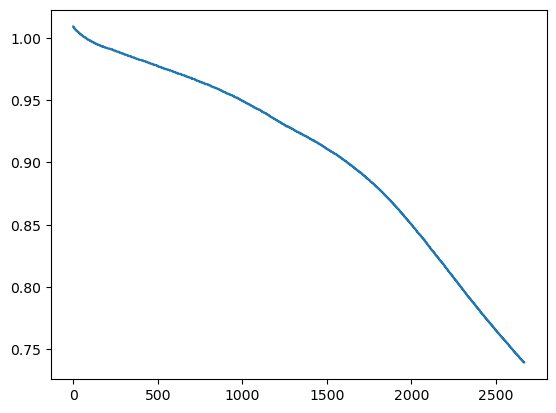

In [22]:
# list(bat1['1-2']['data'].keys())[9:]


n_cyc = 100
in_stride = 10
fea_num = 100

v_low = 3.36
v_upp = 3.60
q_low = 610
q_upp = 1190
rul_factor = 3000
cap_factor = 1190


fea_num =3
def interp(v, q, num):
    f = interpolate.interp1d(v,q,kind='linear')
    v_new = np.linspace(v[0],v[-1],num)
    q_new = f(v_new)
    vq_new = np.concatenate((v_new.reshape(-1,1),q_new.reshape(-1,1)),axis=1)
    return q_new

A_rul = bat1[name]['rul']
A_dq = bat1[name]['dq']
A_df = bat1[name]['data']
all_idx = list(A_dq.keys())[9:]
all_fea, rul_lbl, cap_lbl = [], [], []
for cyc in all_idx:
    tmp = A_df[cyc]
    tmp = tmp.loc[tmp['Status'].apply(lambda x: not 'discharge' in x)]
    
    left = (tmp['Current (mA)']<5000).argmax() + 1
    right = (tmp['Current (mA)']<1090).argmax() - 2

    tmp = tmp.iloc[left:right]

    tmp_v = tmp['Voltage (V)'].values
    tmp_q = tmp['Capacity (mAh)'].values
    tmp_t = tmp['Time (s)'].values
    v_fea = interp(tmp_t, tmp_v, fea_num)
    q_fea = interp(tmp_t, tmp_q, fea_num)

    tmp_fea = np.hstack((v_fea.reshape(-1,1), q_fea.reshape(-1,1)))
    
    all_fea.append(np.expand_dims(tmp_fea,axis=0))
    rul_lbl.append(A_rul[cyc])
    cap_lbl.append(A_dq[cyc])
all_fea = np.vstack(all_fea)
rul_lbl = np.array(rul_lbl)
cap_lbl = np.array(cap_lbl)

all_fea_c = all_fea.copy()
all_fea_c[:,:,0] = (all_fea_c[:,:,0]-v_low)/(v_upp-v_low)
all_fea_c[:,:,1] = (all_fea_c[:,:,1]-q_low)/(q_upp-q_low)
dif_fea = all_fea_c - all_fea_c[0:1,:,:]
all_fea = np.concatenate((all_fea,dif_fea),axis=2)

plt.plot(cap_lbl/cap_factor)
print(len(cap_lbl))

In [14]:

all_fea

array([[[ 3.37230000e+00,  8.59876256e+02,  0.00000000e+00,
          0.00000000e+00],
        [ 3.43435000e+00,  9.98082922e+02,  0.00000000e+00,
          0.00000000e+00],
        [ 3.58560000e+00,  1.13628702e+03,  0.00000000e+00,
          0.00000000e+00]],

       [[ 3.37230000e+00,  8.59871583e+02,  0.00000000e+00,
         -8.05555556e-06],
        [ 3.43400000e+00,  9.97314544e+02, -1.45833333e-03,
         -1.32478927e-03],
        [ 3.58280000e+00,  1.13475396e+03, -1.16666667e-02,
         -2.64321839e-03]],

       [[ 3.37230000e+00,  8.59872344e+02,  0.00000000e+00,
         -6.74329502e-06],
        [ 3.43370000e+00,  9.97313122e+02, -2.70833333e-03,
         -1.32724138e-03],
        [ 3.58350000e+00,  1.13475224e+03, -8.75000000e-03,
         -2.64616858e-03]],

       ...,

       [[ 3.38540000e+00,  6.33835764e+02,  5.45833333e-02,
         -3.89724986e-01],
        [ 3.45250000e+00,  7.32333750e+02,  7.56250000e-02,
         -4.58188228e-01],
        [ 3.58660000e+00

In [57]:
np.expand_dims(tmp_fea,axis=0)

array([[[   3.3751    ,  859.74173611],
        [   3.4365    , 1009.38395556],
        [   3.5869    , 1159.0238    ]]])

In [24]:
bat1['1-1']['dq']

{1: 1174.2992,
 2: 1173.1189555555557,
 3: 1172.5066444444444,
 4: 1171.9004222222222,
 5: 1171.2945333333332,
 6: 1171.2867111111111,
 7: 1170.6743777777779,
 8: 1170.6697111111112,
 9: 1170.6636222222223,
 10: 1170.0476666666666,
 11: 1170.0405333333333,
 12: 1169.4238,
 13: 1169.414288888889,
 14: 1169.4155333333333,
 15: 1168.8119555555556,
 16: 1168.8009777777777,
 17: 1168.804688888889,
 18: 1168.2006888888889,
 19: 1168.195311111111,
 20: 1168.202622222222,
 21: 1167.5969333333333,
 22: 1167.6103555555555,
 23: 1167.5882888888889,
 24: 1167.565,
 25: 1167.5591333333332,
 26: 1167.5221999999999,
 27: 1166.8688222222222,
 28: 1166.8834222222222,
 29: 1166.8656222222223,
 30: 1166.8665777777778,
 31: 1166.2456444444447,
 32: 1166.2467333333334,
 33: 1166.2398,
 34: 1166.2232,
 35: 1166.235488888889,
 36: 1166.2312444444444,
 37: 1165.6056888888888,
 38: 1165.592488888889,
 39: 1165.5801111111111,
 40: 1165.5770222222222,
 41: 1165.5771111111112,
 42: 1164.960888888889,
 43: 1164.95